In [1]:
import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter

In [2]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [3]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [4]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [5]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [6]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [7]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [8]:
def decomposition(mat):
    a,b,c,d = mat[0],mat[1],mat[2],mat[3]
    return 1/4 * np.array( [a+b+c+d, a+b-c-d, a-b+c-d, a-b-c+d] )

In [9]:
def compute_hamiltonian(all_pat,y_var):

    H_ops = []

    for p,yi in zip(all_pat,y_var):
        
        ops = []
        for i in range(0,len(p),2):
            coefs = decomposition(dev_pattern([p[i],p[i+1]]))
            ops.append(SparsePauliOp(["II","ZI","IZ","ZZ"],coefs))
        op = ops[0]
        for i in range(1,len(ops)):
            op = op.tensor(ops[i])
        H_ops.append(op * yi[0])

    #Recover paulis list
    i=0
    while len(H_ops[i].paulis)<=1:
        i+=1
    paulis_idx = H_ops[i].paulis

    #Recover coeffs of H
    H = np.real(np.sum([ op.coeffs for op in H_ops ]))

    return H,paulis_idx

# H,paulis_idx = compute_hamiltonian(all_pat,y)
# for pstring,coef in zip(paulis_idx,H):
#     print(pstring,coef)

In [10]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']

In [11]:
def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                if len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                if len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

6
[0, 16, 18]


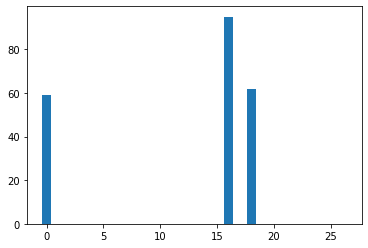

In [13]:
m = 3                       #Number of modes
a = 3                       #Number of possible values
N = int(np.log2(a**m))+1 if (int(np.log2(a**m))+1)%2 == 0 else int(np.log2(a**m))+2    #Number of qubits for encoding

s = 3                       #Sparsity

print(N)
#Random sparse spectrum
spec = np.arange(a**m)
np.random.shuffle(spec)
spec = list(spec[:s])
spec.sort()
spec_val = np.random.randint(50,100,s)
bin_spec = []

for x in spec:
    bin_x = "{0:b}".format(x)
    bin_spec.append('0'*(N-len(bin_x)) + bin_x)

x = [spec_val[spec.index(i)] if (i in spec) else 0 for i in range(a**m)]
plt.bar(range(a**m),x)
plt.plot()
print(spec)

In [39]:
pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 
# all_pat = create_specific_patterns3(0,1,2,N)+create_specific_patterns3(0,1,3,N) + create_specific_patterns3(0,1,4,N) + create_specific_patterns3(0,1,5,N) + create_specific_patterns3(1,2,3,N) + create_specific_patterns3(1,2,5,N) + create_specific_patterns3(2,4,5,N)
# all_pat = create_specific_patterns(0,2,N) + create_specific_patterns(0,3,N) + create_specific_patterns(1,3,N)

l = np.arange(0,N)
np.random.shuffle(l)
r = l[0:3]
r.sort()
all_pat = create_specific_patterns3(r[0],r[1],r[2],N)
for i in range(6):
    np.random.shuffle(l)
    r = l[0:3]
    r.sort()
    all_pat += create_specific_patterns3(r[0],r[1],r[2],N)

print(len(all_pat))

y = np.zeros((len(all_pat),1))
for pat,val in zip(pat_spec,spec_val):
    y += np.matrix([overlapp(pat,p)*val for p in all_pat]).T

A = np.matrix([ dev_pattern(p) for p in all_pat])

print( np.argmax(A.T * y))
print( (A.T*y).shape)
print((A.T*y))

56
16
(64, 1)
[[ 793.]
 [ 485.]
 [ 366.]
 [ 242.]
 [ 426.]
 [ 118.]
 [ 183.]
 [  59.]
 [ 521.]
 [ 213.]
 [ 186.]
 [  62.]
 [ 367.]
 [  59.]
 [ 124.]
 [   0.]
 [1025.]
 [ 717.]
 [ 624.]
 [ 500.]
 [ 560.]
 [ 252.]
 [ 343.]
 [ 219.]
 [ 557.]
 [ 249.]
 [ 248.]
 [ 124.]
 [ 403.]
 [  95.]
 [ 186.]
 [  62.]
 [ 213.]
 [ 213.]
 [ 121.]
 [ 121.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [ 311.]
 [ 311.]
 [ 219.]
 [ 219.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]]


[]

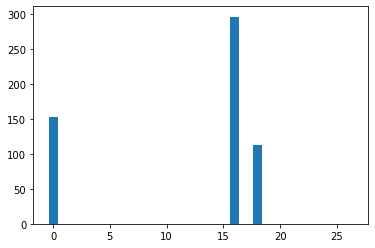

In [40]:
import copy
def matching_pursuit(y,A):

    x_recov = np.zeros((2**N,1))
    r = copy.deepcopy(y)

    for i in range(10):

        v = np.argmax(A.T * r)
        # print(v)

        x_recov[v] = A.T[v]*r
        r -= (0.05*((A.T[v]*r)[0,0]) * A.T[v]).T

    return x_recov
x_recov = matching_pursuit(y,A)
x_recov = list(x_recov.T[0])[:a**m]
plt.bar(range(a**m),x_recov)
plt.plot()

16
[18, 16, 16, 16, 16, 16, 16, 16, 16, 18]
16
[24, 16, 16, 16, 16, 16, 16, 16, 16, 16]
16
[16, 0, 16, 18, 18, 16, 16, 16, 0, 16]
16
[6, 0, 2, 16, 26, 16, 18, 18, 0, 18]
18
[18, 24, 16, 0, 0, 1, 0, 16, 0, 0]
0


[]

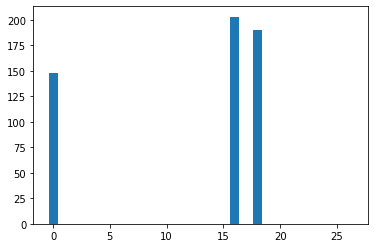

In [33]:
x_recov = np.zeros((2**N,1))

H, paulis_idx = compute_hamiltonian(all_pat,y)

expectation = get_expectation()

res = minimize(expectation, 
                np.ones(30), 
                method='COBYLA')
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,paulis_idx,H)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

z = list(counts.keys())[np.argmax(list(counts.values()))]
v = BitArray(bin='0'+z).int
print(v)
good_v = v

possible_s = np.arange(0.01,0.2,0.02)

for i in range(5):

    x_recov[good_v] = A.T[good_v]*y
    values = []

    for s in possible_s:
        
        y_prime = np.array(y - (s*((A.T[v]*y)[0,0]) * A.T[v]).T)
        H, paulis_idx = compute_hamiltonian(all_pat,y_prime)

        expectation = get_expectation()
        res = minimize(expectation, 
                        np.ones(30), 
                        method='COBYLA')

        qc_res = create_qaoa_circ(res.x,paulis_idx,H)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        z = list(counts.keys())[np.argmax(list(counts.values()))]
        v = BitArray(bin='0'+z).int
        
        values.append(v)
    
    print(values)
    c = Counter(values)
    ma = max(c, key=c.get)
    values = np.array(values)

    good_s = possible_s[np.where(values==ma)]
    good_s = np.max(good_s)
    
    y -= (0.05*((A.T[good_v]*y)[0,0]) * A.T[v]).T
    good_v = ma
    print(good_v)

x_recov[good_v] = A.T[good_v]*y

x_recov = list(x_recov.T[0])[:a**m]
plt.bar(range(a**m),x_recov)
plt.plot()